In [132]:
import numpy as np
import pandas as pd
import keras
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from keras import models
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import statsmodels.tsa.seasonal as smt
from tqdm import tqdm


In [133]:
class DataPreprocessing:
    def __init__(self, data, decomposition_model="additive", rolling_window=12):
        self.data = data
        self.decomposition_model = decomposition_model
        self.rolling_window = rolling_window

    def decompose_data(self):
        decomposition = smt.seasonal_decompose(self.data, model=self.decomposition_model, period=self.rolling_window)
        trend = decomposition.trend.dropna()
        seasonal = decomposition.seasonal.dropna()
        residual = decomposition.resid.dropna()
        return trend, seasonal, residual

    def deseasonalize(self):
        trend, seasonal, residual = self.decompose_data()
        if self.decomposition_model == "additive":
            deseasonalized_data = self.data - seasonal
        elif self.decomposition_model == "multiplicative":
            deseasonalized_data = self.data / seasonal
        return deseasonalized_data.dropna()


In [143]:
# ARIMA-GARCH Forecasting
def arima_garch_forecast(train_data, test_data, p, q):
    """
    Forecast using ARIMA-GARCH model.
    
    Parameters:
    - train_data (pd.Series): Training data for the ARIMA-GARCH model.
    - test_data (pd.Series): Testing data for forecasting.
    - p (int): ARIMA p parameter (autoregressive term).
    - q (int): GARCH q parameter (lagged residual error term).
    
    Returns:
    - forecast (pd.Series): Combined forecast of ARIMA and GARCH models.
    """
    # Fit ARIMA model
    arima_model = ARIMA(train_data, order=(p, 0, q))
    arima_fitted = arima_model.fit()

    # Fit GARCH model on ARIMA residuals
    residuals = arima_fitted.resid
    garch_model = arch_model(residuals, vol="GARCH", p=p, q=q)
    garch_fitted = garch_model.fit(disp="off")

    # Forecast for ARIMA and GARCH
    arima_forecast = arima_fitted.forecast(steps=len(test_data))

    # Forecast GARCH and get the mean forecast for the future time steps
    garch_forecast_result = garch_fitted.forecast(horizon=len(test_data))

    # Print the available columns in the GARCH forecast result for debugging
    print("Available columns in GARCH forecast result:", garch_forecast_result.mean.columns)

    # Access the first column dynamically if column names differ
    garch_forecast = garch_forecast_result.mean.iloc[:, 0]  # First column as forecast

    # Combine the ARIMA and GARCH forecasts
    forecast = arima_forecast + garch_forecast

    return forecast



In [135]:
def lstm_forecast(train_data, test_data, hidden_units, max_epochs):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))

    X_train, y_train = [], []
    for i in range(5, len(train_scaled)):
        X_train.append(train_scaled[i-5:i, 0])
        y_train.append(train_scaled[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(units=hidden_units, input_shape=(X_train.shape[1], 1)))
    model.add(keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=max_epochs, batch_size=1, verbose=2)

    total_data = pd.concat((train_data, test_data), axis=0)
    inputs = total_data[len(total_data) - len(test_data) - 5:].values.reshape(-1, 1)
    inputs_scaled = scaler.transform(inputs)

    X_test = []
    for i in range(5, len(inputs_scaled)):
        X_test.append(inputs_scaled[i-5:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    lstm_predictions = model.predict(X_test)
    lstm_predictions = scaler.inverse_transform(lstm_predictions)

    return lstm_predictions.flatten()

In [136]:

class SCAOptimizer:
    def __init__(self, pop_size, max_iters, dim, lb, ub):
        self.pop_size = pop_size
        self.max_iters = max_iters
        self.dim = dim
        self.lb = lb
        self.ub = ub
        self.population = np.random.uniform(lb, ub, (pop_size, dim))

    def optimize(self, fitness_func):
        best_pos = None
        best_fit = float('inf')

        for t in tqdm(range(self.max_iters), desc="SCA Optimizer Progress"):
            for i in range(self.pop_size):
                fitness = fitness_func(self.population[i])
                if fitness < best_fit:
                    best_fit = fitness
                    best_pos = self.population[i]

            # SCA algorithm to update positions
            a = 2 * (1 - t / self.max_iters)
            for i in range(self.pop_size):
                for j in range(self.dim):
                    r1 = a - t * (a / self.max_iters)
                    r2 = 2 * np.pi * np.random.rand()
                    r3 = np.random.rand()
                    r4 = np.random.rand()

                    if r4 < 0.5:
                        self.population[i, j] = self.population[i, j] + (r1 * np.sin(r2) * abs(r3 * best_pos[j] - self.population[i, j]))
                    else:
                        self.population[i, j] = self.population[i, j] + (r1 * np.cos(r2) * abs(r3 * best_pos[j] - self.population[i, j]))

            # Make sure values stay within bounds
            self.population = np.clip(self.population, self.lb, self.ub)

        return best_pos, best_fit

In [137]:
def calculate_fitness(predictions, actual):
    return np.sqrt(np.mean((predictions - actual) ** 2))

In [138]:
def forecast_arima_garch_lstm(data, best_params):
    long_term, seasonal, residual = DataPreprocessing(data).decompose_data()

    # Split long-term and residual data for train/test
    train_len = int(0.75 * len(long_term))
    test_len = len(long_term) - train_len

    # ARIMA-GARCH Forecast
    arima_garch_predictions = arima_garch_forecast(long_term[:train_len],
                                                   long_term[train_len:],
                                                   p=int(best_params[0]), q=int(best_params[1]))

    # LSTM Forecast
    lstm_predictions = lstm_forecast(residual[:train_len],
                                     residual[train_len:],
                                     hidden_units=int(best_params[2]), max_epochs=int(best_params[3]))

    # Align ARIMA-GARCH and LSTM lengths if different
    min_len = min(len(arima_garch_predictions), len(lstm_predictions))
    arima_garch_predictions = arima_garch_predictions[-min_len:]
    lstm_predictions = lstm_predictions[-min_len:]

    # Combine predictions
    combined_forecast = arima_garch_predictions + lstm_predictions

    return combined_forecast

In [139]:

def save_results_to_csv(actual, forecast, filename='actual_vs_forecast.csv'):
    """
    Save the actual and forecasted values to a CSV file.
    
    Parameters:
    - actual (pd.Series): Actual values of the stock prices.
    - forecast (pd.Series): Forecasted values from the model.
    - filename (str): Output filename for the CSV.
    
    Returns:
    - None
    """
    results_df = pd.DataFrame({
        'Actual': actual[-len(forecast):].values,  # Aligning the forecast with the actual values
        'Forecast': forecast
    })
    results_df.to_csv(filename, index=False)
    print(f"Results saved to {filename}")


In [140]:
def plot_results(actual, forecast):
    """
    Plot the actual and forecasted values.
    
    Parameters:
    - actual (pd.Series): Actual stock prices.
    - forecast (pd.Series): Forecasted prices from the model.
    
    Returns:
    - None
    """
    plt.figure(figsize=(12, 6))
    plt.plot(actual.index, actual, label="Actual Data", color='steelblue', linewidth=2)
    plt.plot(actual.index[-len(forecast):], forecast, label="Forecast", linestyle="--", color='orange', linewidth=2)
    plt.title("ARIMA-GARCH-LSTM Predictions")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


In [141]:
def run_full_workflow(data, best_params=None, best_fitness=None):
    """
    Run the full ARIMA-GARCH-LSTM workflow. Optionally, provide best parameters and fitness.
    
    Parameters:
    - data (pd.DataFrame): The input stock price data.
    - best_params (list): Predefined best parameters for the model (optional).
    - best_fitness (float): Predefined best fitness value (optional).
    
    Returns:
    - None
    """
    # Decompose the data
    preprocessing = DataPreprocessing(data)
    long_term, seasonal, residual = preprocessing.decompose_data()

    # Define bounds for SCA optimization
    lb = [1, 1, 10, 10]  # p, q, hidden_units, max_epochs
    ub = [5, 5, 100, 100]

    # Check if best_params and best_fitness are provided
    if best_params is None or best_fitness is None:
        # If not provided, run SCA optimizer
        print("No predefined parameters provided. Running SCA optimization...")
        sca_optimizer = SCAOptimizer(pop_size=1, max_iters=1, dim=4, lb=lb, ub=ub)

        # Run SCA optimization
        best_params, best_fitness = sca_optimizer.optimize(lambda params: calculate_fitness(forecast_arima_garch_lstm(data, params), data))

    print(f"Best Parameters: {best_params}, Best Fitness: {best_fitness}")

    # Forecast with the best parameters
    actual = data# Assuming 'Close' is your actual stock price column
    forecast = forecast_arima_garch_lstm(data, best_params)

    save_results_to_csv(actual, forecast)
    plot_results(actual, forecast)



Best Parameters: [1.96426626, 2.83651651, 20.13242557, 47.35318882], Best Fitness: 0.8977879867010543


C:\CoDE\workspace-idea\everything\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\CoDE\workspace-idea\everything\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\CoDE\workspace-idea\everything\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\CoDE\workspace-idea\everything\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\CoDE\workspace-idea\everything\venv\Lib\site-packages\statsmodels\tsa\state

Available columns in GARCH forecast result: Index(['h.001', 'h.002', 'h.003', 'h.004', 'h.005', 'h.006', 'h.007', 'h.008',
       'h.009', 'h.010',
       ...
       'h.806', 'h.807', 'h.808', 'h.809', 'h.810', 'h.811', 'h.812', 'h.813',
       'h.814', 'h.815'],
      dtype='object', length=815)
Epoch 1/47


C:\CoDE\workspace-idea\everything\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\CoDE\workspace-idea\everything\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\CoDE\workspace-idea\everything\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2438/2438 - 4s - 2ms/step - loss: 0.0242
Epoch 2/47
2438/2438 - 3s - 1ms/step - loss: 0.0219
Epoch 3/47
2438/2438 - 3s - 1ms/step - loss: 0.0217
Epoch 4/47
2438/2438 - 3s - 1ms/step - loss: 0.0216
Epoch 5/47
2438/2438 - 3s - 1ms/step - loss: 0.0216
Epoch 6/47
2438/2438 - 4s - 1ms/step - loss: 0.0215
Epoch 7/47
2438/2438 - 3s - 1ms/step - loss: 0.0215
Epoch 8/47
2438/2438 - 3s - 1ms/step - loss: 0.0216
Epoch 9/47
2438/2438 - 3s - 1ms/step - loss: 0.0215
Epoch 10/47
2438/2438 - 3s - 1ms/step - loss: 0.0215
Epoch 11/47
2438/2438 - 3s - 1ms/step - loss: 0.0212
Epoch 12/47
2438/2438 - 3s - 1ms/step - loss: 0.0214
Epoch 13/47
2438/2438 - 3s - 1ms/step - loss: 0.0213
Epoch 14/47
2438/2438 - 3s - 1ms/step - loss: 0.0214
Epoch 15/47
2438/2438 - 3s - 1ms/step - loss: 0.0214
Epoch 16/47
2438/2438 - 3s - 1ms/step - loss: 0.0213
Epoch 17/47
2438/2438 - 3s - 1ms/step - loss: 0.0213
Epoch 18/47
2438/2438 - 3s - 1ms/step - loss: 0.0213
Epoch 19/47
2438/2438 - 3s - 1ms/step - loss: 0.0213
Epoch 20/47
2

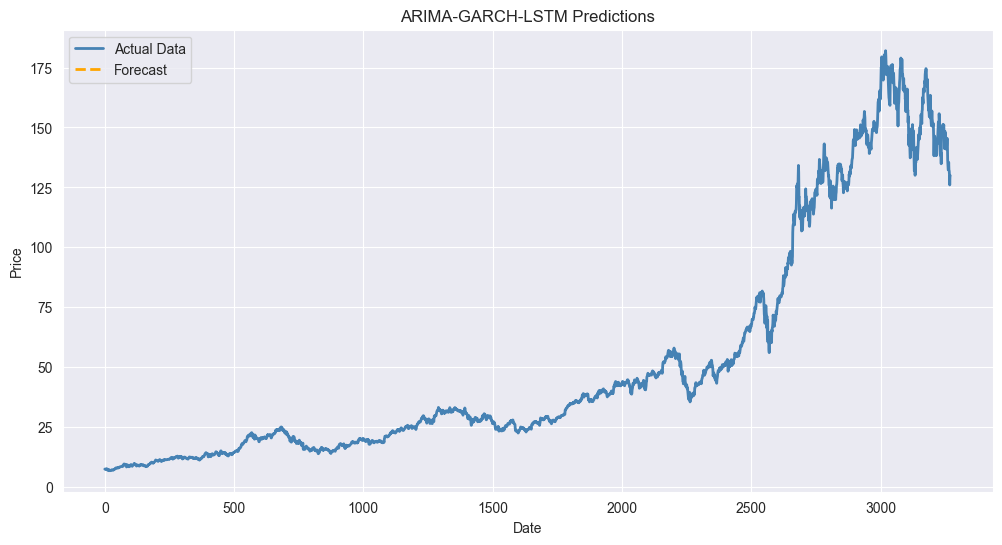

In [144]:
data = pd.read_csv('../data/processed/AAPL.csv')
best_params = [1.96426626, 2.83651651, 20.13242557, 47.35318882]
best_fitness = 0.8977879867010543

run_full_workflow(data['Close'], best_params, best_fitness)